In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATASET_PATH = 'data_prediksi_gagal_jantung.csv'


In [ ]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
#Step1: Loading & Transforming the Dataset//Langkah 1: Memuat dan Mengubah Dataset
df = pd.read_csv(DATASET_PATH)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# Convert categorical columns to numerical using one-hot encoding//Ubah kolom kategoris menjadi numerik menggunakan pengkodean one-hot
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_F              918 non-null    bool   
 8   Sex_M              918 non-null    bool   
 9   ChestPainType_ASY  918 non-null    bool   
 10  ChestPainType_ATA  918 non-null    bool   
 11  ChestPainType_NAP  918 non-null    bool   
 12  ChestPainType_TA   918 non-null    bool   
 13  RestingECG_LVH     918 non-null    bool   
 14  RestingECG_Normal  918 non-null    bool   
 15  RestingECG_ST      918 non-null    bool   
 16  ExerciseAngina_N   918 non

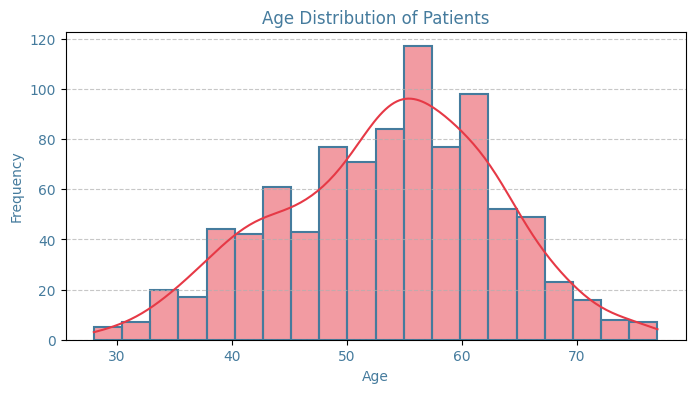

In [ ]:
#Step 2: Exploratory Data Analysis
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=20, kde=True, color='#e63946', edgecolor='#457b9d', linewidth=1.5)
plt.title('Age Distribution of Patients', color='#457b9d')
plt.xlabel('Age', color='#457b9d')
plt.ylabel('Frequency', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

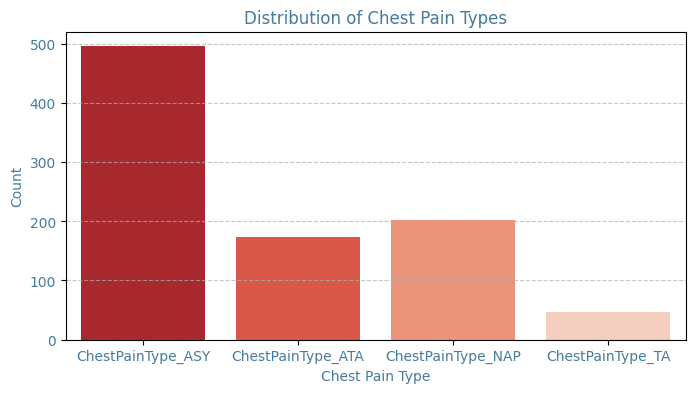

In [ ]:
#Chest Pain Type Distribution
plt.figure(figsize=(8, 4))
chest_pain_counts = df[['ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA']].sum()
sns.barplot(x=chest_pain_counts.index, y=chest_pain_counts.values, palette='Reds_r')
plt.title('Distribution of Chest Pain Types', color='#457b9d')
plt.xlabel('Chest Pain Type', color='#457b9d')
plt.ylabel('Count', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

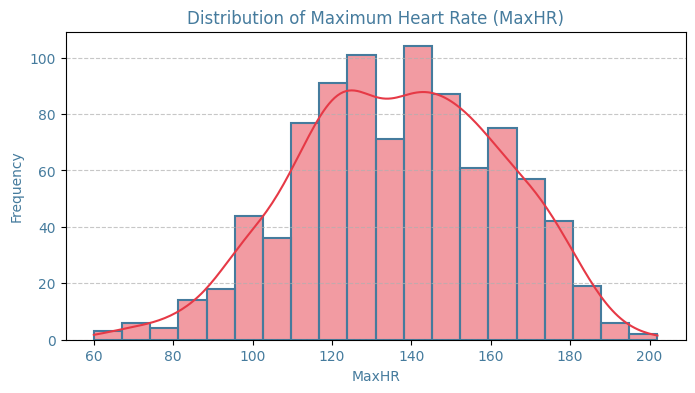

In [ ]:
#MaxHR Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['MaxHR'], bins=20, kde=True, color='#e63946', edgecolor='#457b9d', linewidth=1.5)
plt.title('Distribution of Maximum Heart Rate (MaxHR)', color='#457b9d')
plt.xlabel('MaxHR', color='#457b9d')
plt.ylabel('Frequency', color='#457b9d')
plt.xticks(color='#457b9d')
plt.yticks(color='#457b9d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

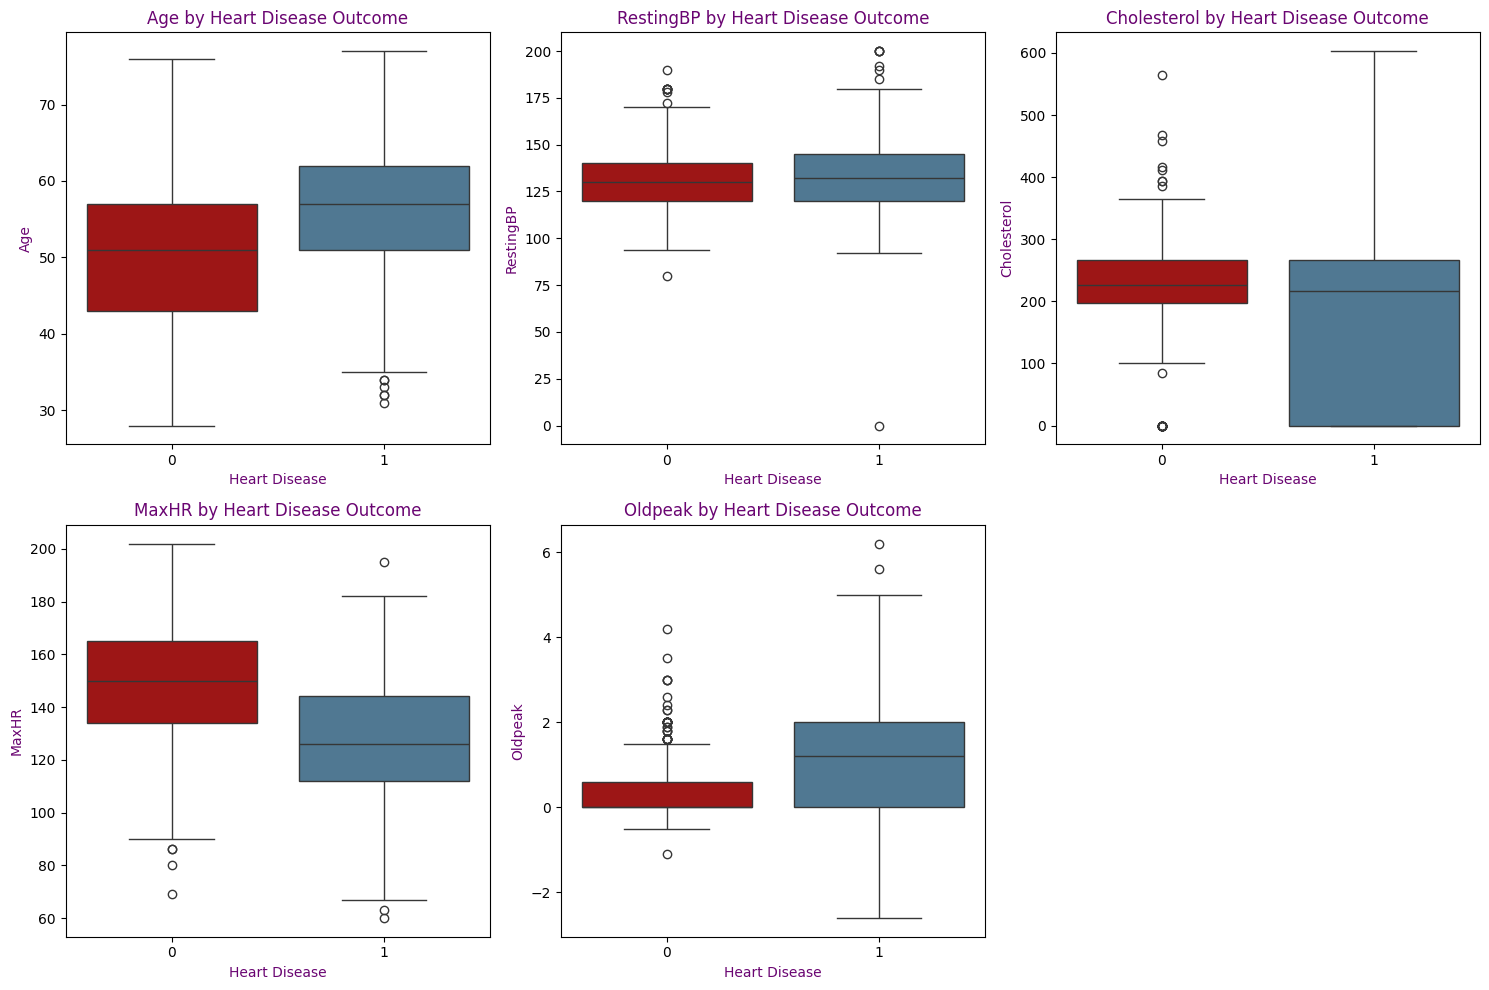

In [ ]:
#Box Plots for Age, RestingBP, Cholesterol, MaxHR, and Oldpeak by Heart Disease Outcome
plt.figure(figsize=(15, 10))
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
colors = ['#b30000', '#457b9d']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x='HeartDisease', y=feature, palette=colors)
    plt.title(f'{feature} by Heart Disease Outcome', color='#6a0572')
    plt.xlabel('Heart Disease', color='#6a0572')
    plt.ylabel(feature, color='#6a0572')
plt.tight_layout()
plt.show()

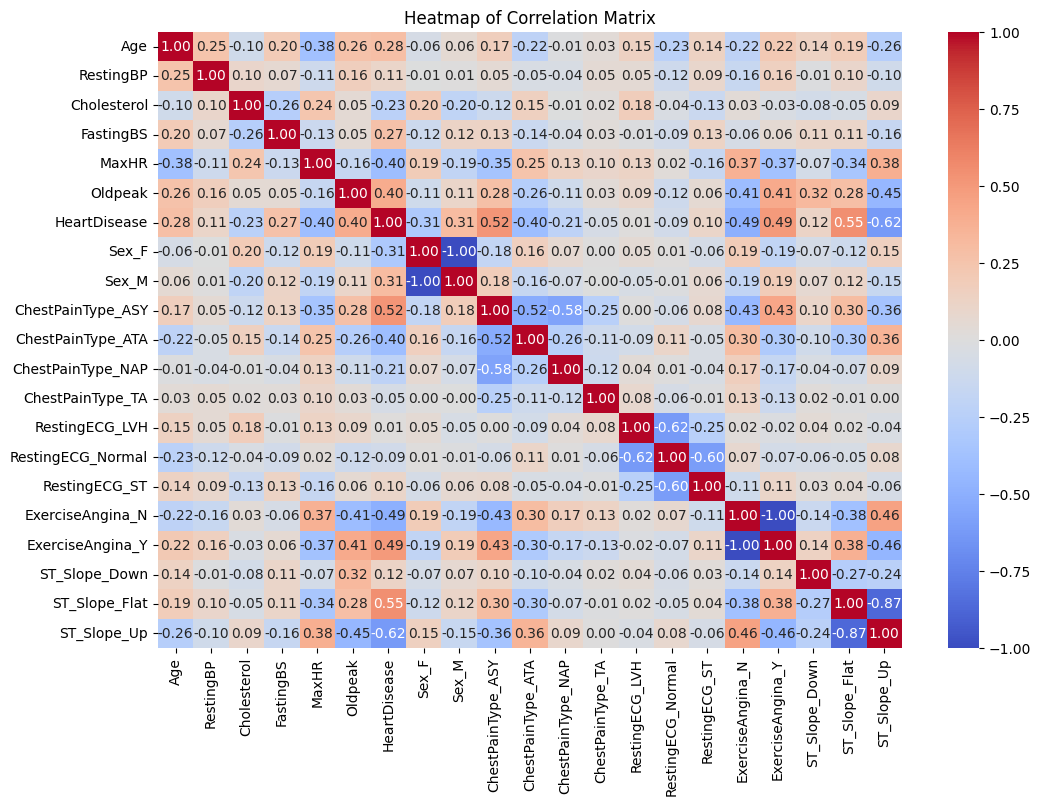

In [ ]:
#Heatmap of Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.show()

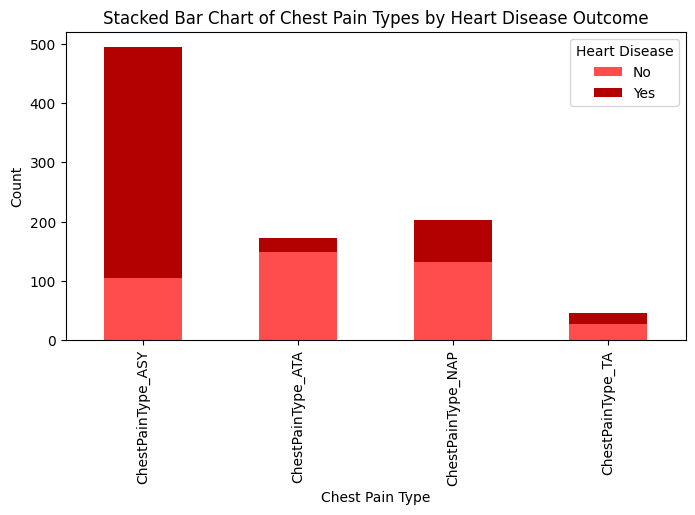

In [ ]:
#Stacked Bar Chart for Chest Pain Types by Heart Disease Outcome
# Define heart-themed colors
heart_colors = ['#ff4d4d', '#b30000']  # Purple for Heart Disease No, Light Blue for Heart Disease Yes

# Chest pain types
chest_pain_types = ['ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA']

# Transpose the grouped data for plotting
heart_disease_outcome = df.groupby('HeartDisease')[chest_pain_types].sum().transpose()

# Plot
heart_disease_outcome.plot(kind='bar', stacked=True, figsize=(8, 4), color=heart_colors)
plt.title('Stacked Bar Chart of Chest Pain Types by Heart Disease Outcome')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'], loc='upper right')
plt.show()

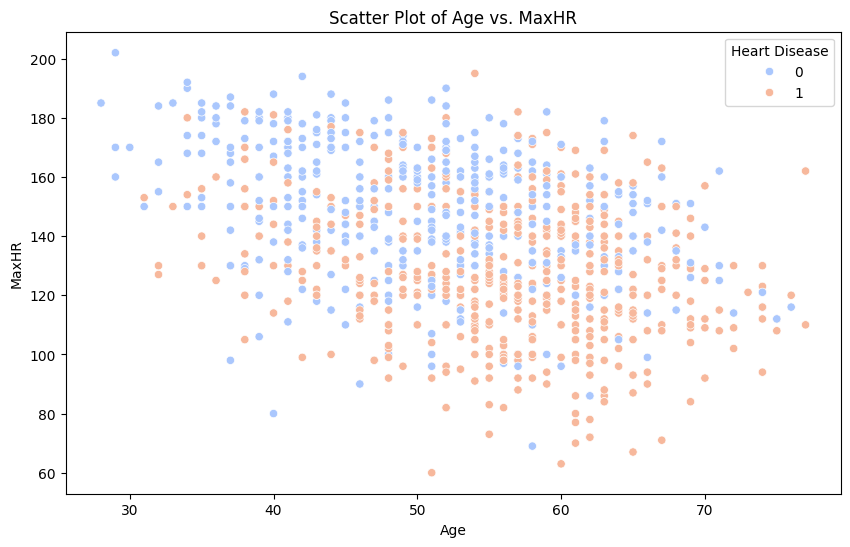

In [ ]:
#Scatter Plot for Age vs. MaxHR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue='HeartDisease', palette='coolwarm')
plt.title('Scatter Plot of Age vs. MaxHR')
plt.xlabel('Age')
plt.ylabel('MaxHR')
plt.legend(title='Heart Disease')
plt.show()

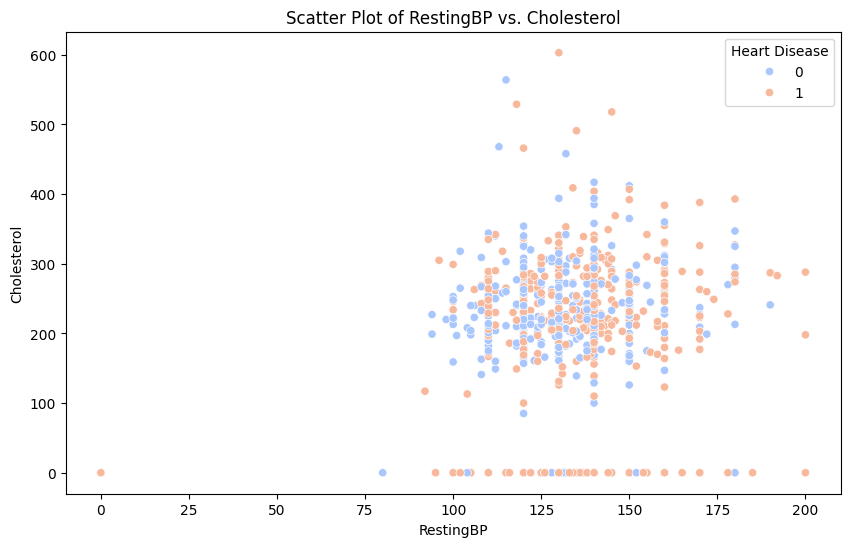

In [ ]:
#Scatter Plot for RestingBP vs. Cholesterol
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RestingBP', y='Cholesterol', hue='HeartDisease', palette='coolwarm')
plt.title('Scatter Plot of RestingBP vs. Cholesterol')
plt.xlabel('RestingBP')
plt.ylabel('Cholesterol')
plt.legend(title='Heart Disease')
plt.show()

In [ ]:
#Step 3: Outlier Analysis
# Columns to analyze
columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Detect outliers for each column and count them
outliers_dict = {}
for column in columns:
    outliers = detect_outliers(df, column)
    outliers_dict[column] = outliers

# Summary of outliers in each column
for column in outliers_dict:
    print(f"{column}: {len(outliers_dict[column])}")

Age: 0
RestingBP: 28
Cholesterol: 183
MaxHR: 2
Oldpeak: 16


In [ ]:
#Step 4: Spliting the dataset
# Select features and target variable
X = df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
        'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
        'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
        'ExerciseAngina_N', 'ExerciseAngina_Y',
        'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']]
y = df['HeartDisease']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Step 5: Fitting SVM (Support Vector Machine)
# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [ ]:
# Evaluate the model on test data
y_pred = svm_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8913


In [ ]:
# Print classification report for more details
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.90      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [ ]:
#Step 6: Fitting ANN (Aritifical Neural Network)
# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5340 - loss: 0.7423 - val_accuracy: 0.7554 - val_loss: 0.5618
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7309 - loss: 0.5497 - val_accuracy: 0.7880 - val_loss: 0.4783
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7708 - loss: 0.4813 - val_accuracy: 0.8315 - val_loss: 0.4179
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8136 - loss: 0.4326 - val_accuracy: 0.8478 - val_loss: 0.3868
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8657 - loss: 0.3902 - val_accuracy: 0.8424 - val_loss: 0.3627
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8471 - loss: 0.3809 - val_accuracy: 0.8478 - val_loss: 0.3615
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8212 - loss: 0.4371 - val_accuracy: 0.8478 - val_loss: 0.3519
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8720 - loss: 0.3610 - val_accuracy: 0.8641 

In [ ]:
# Save history into a df
df_ann_history = pd.DataFrame(history.history)

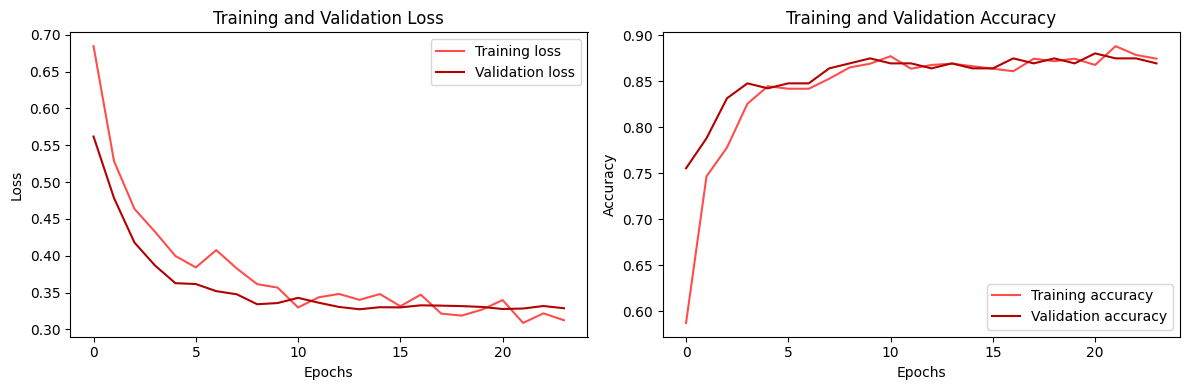

In [ ]:
# Set heart-related colors
heart_colors = ['#ff4d4d', '#b30000']  # Red shades for loss and accuracy

# Plot both loss and accuracy in a single grid
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(df_ann_history['loss'], heart_colors[0], label='Training loss')
plt.plot(df_ann_history['val_loss'], heart_colors[1], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(df_ann_history['accuracy'], heart_colors[0], label='Training accuracy')
plt.plot(df_ann_history['val_accuracy'], heart_colors[1], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Step 7: Fitting CNN (Convolutional Neural Network)
# Reshape X_train_scaled and X_test_scaled for CNN input
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

In [ ]:
# Build the CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the CNN model
cnn_history = cnn_model.fit(X_train_cnn, y_train,
                            epochs=100,
                            batch_size=32,
                            validation_data=(X_test_cnn, y_test),
                            callbacks=[early_stopping])

# Evaluate the CNN model on test data
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test)

print(f'Test Accuracy (CNN): {test_accuracy_cnn:.4f}')
print(f'Test Loss (CNN): {test_loss_cnn:.4f}')

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5542 - loss: 0.6884 - val_accuracy: 0.8098 - val_loss: 0.5895
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6880 - loss: 0.6071 - val_accuracy: 0.8315 - val_loss: 0.4955
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7562 - loss: 0.5356 - val_accuracy: 0.8424 - val_loss: 0.4306
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7282 - loss: 0.5350 - val_accuracy: 0.8315 - val_loss: 0.4075
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7540 - loss: 0.5338 - val_accuracy: 0.8478 - val_loss: 0.4090
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7581 - loss: 0.5064 - val_accuracy: 0.8478 - val_loss: 0.4068
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7829 - loss: 0.4616 - val_accuracy: 0.8533 - val_loss: 0.3942
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7923 - loss: 0.4433 - val_accuracy: 0.8424 

In [ ]:
# Save history into a df
df_cnn_history = pd.DataFrame(cnn_history.history)

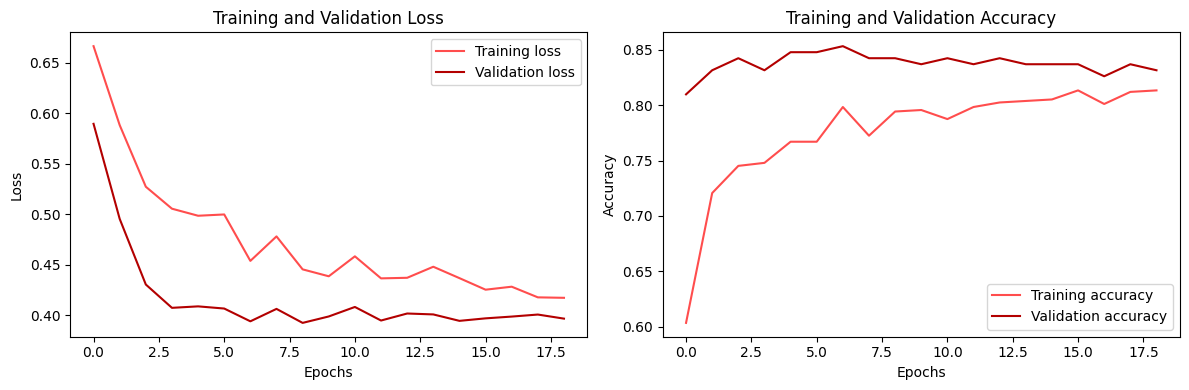

In [ ]:
# Set heart-related colors
heart_colors = ['#ff4d4d', '#b30000']  # Red shades for loss and accuracy

# Plot both loss and accuracy in a single grid
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(df_cnn_history['loss'], heart_colors[0], label='Training loss')
plt.plot(df_cnn_history['val_loss'], heart_colors[1], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(df_cnn_history['accuracy'], heart_colors[0], label='Training accuracy')
plt.plot(df_cnn_history['val_accuracy'], heart_colors[1], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()